In [1]:
from src.evaluation import matching
from src.models import model_loader
import pickle
import numpy as np
import torch
import argparse
import sys
import os
from src.models import SPITE
model_type_to_modalities = {
    "S" : "SKELETON",
    "I" : "IMU",
    "P" : "PC"
}

In [2]:
print("Loading data.")
path_to_dataset = "/data/LIPD/LIPD_SEQUENCES_256p.pkl"
with open(path_to_dataset, 'rb') as f:
    sequence_datasets = pickle.load(f)

Loading data.


In [12]:
sequence_datasets["eLIPD"]["923"]['seq2'].keys()

dict_keys(['PCD', 'IMU', 'gt_joint', 'gt'])

In [15]:
sequence_datasets["eLIPD"]["923"]['seq2']["gt_joint"].shape

torch.Size([3951, 72])

In [15]:
src_modality = "IMU"
tgt_modality = "PC"
embed_dim = 512
num_joints = 24 # keep this the same because we have only one dataset.
n_feats = 3 # keep this the same because we have only one dataset.

In [11]:
model_type = "SPIE"
modalities = [model_type_to_modalities[m].lower() for m in model_type if not m in ["E", "T"]]

In [16]:
skeleton = model_loader.load_skeleton_encoder(embed_dim, num_joints, n_feats, device="cuda") if "skeleton" in modalities else None
imu = model_loader.load_imu_encoder(embed_dim, device="cuda") if "imu" in modalities else None
pc = model_loader.load_pst_transformer(embed_dim, device="cuda") if "pc" in modalities else None
skeleton_gen = None
model = SPITE.instantiate_binder(modalities, False, imu, pc, skeleton, skeleton_gen).to("cuda")

Loading class <class 'src.models.SPITE.SPIE_BINDER'>


In [17]:
#model_path = "/data/ICCV_RESULTS/ICCV/models/vast_2/wandb/run-20250301_072105-nsi1z316/files/model_145.pth"
model_path = "/data/ICCV_RESULTS/OpenAccess/model_weights/v1/SPIE_v1.pth"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [18]:
m = "eLIPD"
test_subj_dataset = matching.encode_all(sequence_datasets[m], model, window_length=24, model_type=model_type)

# Matching Demo

In [743]:
n_subjects = 8
n_window_size = 160
n_scenes = 1

augmented_scenes = matching.create_augmented_scenes_with_windows(test_subj_dataset, num_windows=n_subjects, 
                                                        window_size=n_window_size, n_scenes=n_scenes, 
                                                        src_modality=src_modality, tgt_modality=tgt_modality)

In [744]:
# Compute matching
scene = augmented_scenes[0]
predicted_matches = []
sims = []

imu_embs = scene["%s_embs" % src_modality]
pcd_embs = scene["%s_embs" % tgt_modality]
ground_truth = np.arange(len(imu_embs))
for imu_query in imu_embs:
    ### Find closest match.
    best_match_index, similarities = matching.match_imu_window_to_lidar(imu_query, pcd_embs)
    predicted_matches.append(best_match_index)
    sims.append(similarities)
results = [predicted_matches, ground_truth]

In [745]:
from tqdm import tqdm

In [746]:
# Compute matching for each frame
scene = augmented_scenes[0]
predicted_matches = []
sims = []
sims_frames = []
imu_embs = scene["%s_embs" % src_modality]
pcd_embs = scene["%s_embs" % tgt_modality]
ground_truth = np.arange(len(imu_embs))
for frame in tqdm(range(imu_embs.shape[1])):
    sims = []
    for imu_query in imu_embs[:,frame]:
        ### Find closest match.
        best_match_index, similarities = matching.match_imu_window_to_lidar(imu_query, pcd_embs[:,frame])
        predicted_matches.append(best_match_index)
        sims.append(similarities)
    sims_frames.append(sims)
    #results = [predicted_matches, ground_truth]

100%|██████████| 160/160 [03:01<00:00,  1.14s/it]


### Visualization Matching across Frames

In [838]:
pcs = scene["PC"][:,:,0]
imus = scene["IMU"][:,:,0]
sims_f = np.array(sims_frames)

In [839]:
pcs.shape

torch.Size([8, 160, 256, 3])

In [841]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from tqdm import tqdm
import imageio
import os
from scipy.ndimage import binary_dilation
import imageio_ffmpeg

# === CONFIG ===
FRAME_COUNT = n_window_size
FPS = 15
WHITE_THRESHOLD = 245
PAD_ROWS = 5
os.makedirs("frames", exist_ok=True)

# === Helper: Pad cropped image to target size, centered ===
def pad_to_center(image, target_size, fill=(255, 255, 255)):
    w, h = image.size
    target_w, target_h = target_size
    pad_left = (target_w - w) // 2
    pad_top = (target_h - h) // 2
    pad_right = target_w - w - pad_left
    pad_bottom = target_h - h - pad_top
    return ImageOps.expand(image, border=(pad_left, pad_top, pad_right, pad_bottom), fill=fill)

# === Helper: Compute fixed crop bounds across all images ===
def get_global_crop_bounds(images, threshold=WHITE_THRESHOLD, pad=PAD_ROWS):
    all_row_masks = []

    for img in images:
        arr = np.asarray(img)
        gray = arr.mean(axis=2)
        row_mask = (gray < threshold).any(axis=1)
        row_mask = binary_dilation(row_mask, iterations=pad)
        all_row_masks.append(row_mask)

    combined = np.stack(all_row_masks, axis=0)
    final_mask = combined.any(axis=0)
    top, bottom = np.where(final_mask)[0][[0, -1]]
    return top, bottom

# === Helper: Auto-remove white horizontal bands in the middle ===
def remove_middle_white_bands_with_padding(images, threshold=245, pad_margin=5):
    """Detect persistent horizontal white bands and replace them with smaller white gaps."""
    arrs = [np.asarray(img) for img in images]
    h, w = arrs[0].shape[:2]

    # Step 1: detect always-white rows
    white_rows_all = []
    for arr in arrs:
        gray = arr.mean(axis=2)
        white_rows = (gray > threshold).all(axis=1)
        white_rows_all.append(white_rows)

    stacked = np.stack(white_rows_all, axis=0)
    always_white = stacked.all(axis=0)

    # Step 2: identify bands
    bands = []
    in_band = False
    for i, val in enumerate(always_white):
        if val and not in_band:
            band_start = i
            in_band = True
        elif not val and in_band:
            band_end = i
            bands.append((band_start, band_end))
            in_band = False
    if in_band:
        bands.append((band_start, h))

    # Step 3: Replace band with small padding block (white rows)
    new_images = []
    for arr in arrs:
        rows = []
        prev = 0
        for band_start, band_end in bands:
            # Keep part above band
            rows.append(arr[prev:band_start])
            # Insert new white padding block
            white_block = np.ones((pad_margin, w, 3), dtype=np.uint8) * 255
            rows.append(white_block)
            prev = band_end
        # Append remaining bottom rows
        rows.append(arr[prev:])
        final = np.vstack(rows)
        new_images.append(Image.fromarray(final))

    return new_images


N_SUBJECTS = n_subjects
# === Main loop for each query subject ===
for QUERY_IDX in range(N_SUBJECTS):
    OUTPUT_VIDEO = f"similarity_visualization_{QUERY_IDX}.mp4"
    frame_paths = []

    # === Step 1: Render and save raw frames ===
    for t in tqdm(range(FRAME_COUNT), desc=f"Query {QUERY_IDX}"):
        query_sims = sims_f[t, QUERY_IDX]
        colors = cm.cool(query_sims / query_sims.max())

        fig = plt.figure(figsize=(12, 8))
        gs = GridSpec(2, 2, height_ratios=[2, 1], hspace=0.3)

        # --- 3D Point Cloud ---
        ax3d = fig.add_subplot(gs[0, :], projection='3d')
        scale = 20
        spacing = scale / 1 + 2

        for i in range(N_SUBJECTS):
            cloud = pcs[i][t]
            x = cloud[:, 0] * scale + i * spacing
            y = cloud[:, 1] * scale
            z = cloud[:, 2] * scale
            ax3d.scatter(x, y, z, c=[colors[i]] * len(x), s=3, alpha=0.9)
            ax3d.text(i * spacing, -1.3, -23.5, f"Subject {i+1}", ha='center',
                      bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8), fontsize=12)

        total_width = (N_SUBJECTS + 1) * spacing
        ax3d.set_xlim(-2, 170)
        ax3d.set_ylim(-1.5, 1.5)
        ax3d.set_zlim(-0.25, 0.45)
        ax3d.set_box_aspect([total_width, 2, 1])
        ax3d.view_init(elev=10, azim=270)
        ax3d.axis('off')
        ax3d.set_position([0, 0.25, 1, 1])
        ax3d.patch.set_visible(False)

        # --- IMU Plot ---
        ax2d = fig.add_subplot(gs[1, 0])
        imu_seq = imus[QUERY_IDX].numpy()
        for c in [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]:
            ax2d.plot(imu_seq[:t+1, c])
        ax2d.set_xlim(0, FRAME_COUNT)
        ax2d.set_ylim(np.min(imu_seq), np.max(imu_seq))
        ax2d.set_title(f"IMU Sequence - Subject {QUERY_IDX+1}", fontsize=12, fontweight='bold')
        ax2d.tick_params(labelsize=10)

        # --- Similarity Bar Plot ---
        ax_bar = fig.add_subplot(gs[1, 1])
        bars = ax_bar.bar(np.arange(N_SUBJECTS), query_sims, color=[colors[i] for i in range(N_SUBJECTS)])
        bars[QUERY_IDX].set_edgecolor("black")
        bars[QUERY_IDX].set_linewidth(2)
        bars[QUERY_IDX].set_hatch("//")
        ax_bar.set_ylim(0, 1)
        ax_bar.set_xticks(np.arange(N_SUBJECTS))
        ax_bar.set_xticklabels([f"S{i+1}" for i in range(N_SUBJECTS)])
        ax_bar.set_title("Cosine Similarity to Query IMU", fontsize=12, fontweight='bold')
        ax_bar.tick_params(labelsize=10)

        frame_path = f"frames/frame_{QUERY_IDX}_{t:03d}.png"
        plt.savefig(frame_path, dpi=300, bbox_inches='tight', pad_inches=0.05)
        plt.close(fig)
        frame_paths.append(frame_path)

    # === Step 2: Load and crop top/bottom ===
    raw_images = [Image.open(p).convert("RGB") for p in frame_paths]
    top, bottom = get_global_crop_bounds(raw_images)
    cropped_images = [img.crop((0, top, img.width, bottom)) for img in raw_images]

    # === Step 3: Auto-remove middle white bands ===
    cleaned_images = remove_middle_white_bands_with_padding(cropped_images)

    # === Step 4: Pad and export video ===
    max_w = max(img.size[0] for img in cleaned_images)
    max_h = max(img.size[1] for img in cleaned_images)
    target_size = (max_w, max_h)
    frames = [np.array(pad_to_center(img, target_size)) for img in cleaned_images]

    imageio.mimsave(OUTPUT_VIDEO, frames, fps=FPS)
    print(f"✅ Saved video: {OUTPUT_VIDEO}")


Query 6: 100%|██████████| 160/160 [01:53<00:00,  1.41it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2910, 1506) to (2912, 1520) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Query 7:   0%|          | 0/160 [00:00<?, ?it/s]

✅ Saved video: similarity_visualization_6.mp4


Query 7: 100%|██████████| 160/160 [01:48<00:00,  1.47it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2910, 1506) to (2912, 1520) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


✅ Saved video: similarity_visualization_7.mp4


# Temporal Search Demo

In [757]:
query = test_subj_dataset["921"]["seq2"]["IMU_EMBS"]
target = test_subj_dataset["921"]["seq2"]["PC_EMBS"]

In [758]:
import numpy as np
q = np.random.choice(np.arange(len(query)), 3)[0]

In [760]:
similarities = torch.matmul(target, query[q])

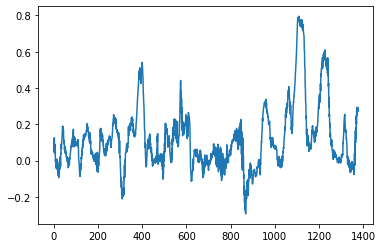

In [761]:
plt.plot(similarities)

In [771]:
len(similarities), len(query_signal)

(1377, 1377)

In [785]:
query_signal = test_subj_dataset["921"]["seq2"]["IMU"][23:,-12:] # show only accelerometer
target_signal = test_subj_dataset["921"]["seq2"]["PC"][23:, :] 

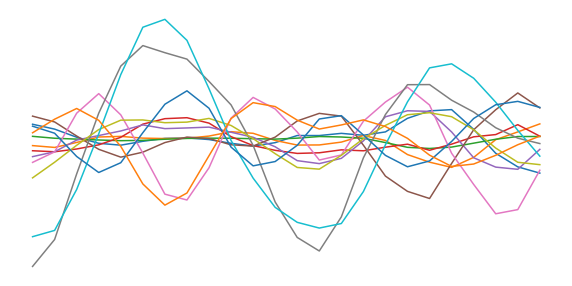

In [849]:
plt.figure(figsize=(10,5))
plt.plot(imu_query)
plt.axis("off")
plt.savefig("imu_query.png", dpi=300)

In [776]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm
import io

imu_full = query_signal.numpy()

frames = []
for t in tqdm(range(1, imu_full.shape[0] + 1)):
    fig, ax = plt.subplots(figsize=(8, 3))

    for c in range(imu_full.shape[1]):
        ax.plot(imu_full[:t, c], linewidth=1, label=f'C{c}')

    ax.set_xlim(0, imu_full.shape[0])
    ax.set_ylim(np.min(imu_full), np.max(imu_full))
    ax.set_title("Full IMU Time Series", fontsize=14, fontweight='bold')
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.tick_params(labelsize=8)
    plt.tight_layout()

    # === Convert to image (no file saving) ===
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=100)
    plt.close(fig)
    buf.seek(0)
    image = Image.open(buf).convert('RGB')
    frames.append(np.array(image))
    buf.close()

# Save video
imageio.mimsave("imu_full_animation.mp4", frames, fps=60)

100%|██████████| 1377/1377 [02:03<00:00, 11.14it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (800, 300) to (800, 304) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [835]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm
import io

imu_query = query_signal[q-23:q+1].numpy()

frames = []
for t in tqdm(range(1, imu_query.shape[0] + 1)):
    fig, ax = plt.subplots(figsize=(8, 3))

    for c in range(imu_query.shape[1]):
        ax.plot(imu_query[:t, c], linewidth=1, label=f'C{c}')

    ax.set_xlim(0, imu_query.shape[0])
    ax.set_ylim(np.min(imu_query), np.max(imu_query))
    ax.set_title("Query IMU Time Series", fontsize=14, fontweight='bold')
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.tick_params(labelsize=8)
    plt.tight_layout()

    # === Convert to image (no file saving) ===
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=300)
    plt.close(fig)
    buf.seek(0)
    image = Image.open(buf).convert('RGB')
    frames.append(np.array(image))
    buf.close()

# Save video
imageio.mimsave("imu_query_animation.mp4", frames, fps=24)

100%|██████████| 24/24 [00:05<00:00,  4.74it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2400, 900) to (2400, 912) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [804]:
pcs = target_signal
all_points = np.concatenate(pcs.numpy(), axis=0)
center = all_points.mean(axis=0)
range_scale = 0.5  # how tight the zoom is

xlim = (center[0] - range_scale, center[0] + range_scale)
ylim = (center[1] - range_scale, center[1] + range_scale)
zlim = (center[2] - range_scale, center[2] + range_scale)

frames = []

for t in tqdm(range(len(pcs))):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    
    pc = pcs[t]
    ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=5, alpha=1)

    # Consistent axis limits
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_zlim(*zlim)

    # Fixed view
    ax.view_init(elev=20, azim=270)
    ax.axis('off')

    # Convert to image
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=100, bbox_inches='tight', pad_inches=0.05)
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf).convert("RGB")
    frames.append(np.array(img))
    buf.close()

# Save video
imageio.mimsave("pointcloud_sequence.mp4", frames, fps=60)

100%|██████████| 1377/1377 [00:54<00:00, 25.33it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (387, 387) to (400, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [834]:
pcs = target_signal[q-23:q+1]
all_points = np.concatenate(pcs.numpy(), axis=0)
center = all_points.mean(axis=0)
range_scale = 0.5  # how tight the zoom is

xlim = (center[0] - range_scale, center[0] + range_scale)
ylim = (center[1] - range_scale, center[1] + range_scale)
zlim = (center[2] - range_scale, center[2] + range_scale)

frames = []

for t in tqdm(range(len(pcs))):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    
    pc = pcs[t]
    ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=5, alpha=1)

    # Consistent axis limits
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_zlim(*zlim)

    # Fixed view
    ax.view_init(elev=20, azim=270)
    ax.axis('off')

    # Convert to image
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=300, bbox_inches='tight', pad_inches=0.05)
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf).convert("RGB")
    frames.append(np.array(img))
    buf.close()

# Save video
imageio.mimsave("query_pointcloud_sequence.mp4", frames, fps=24)

100%|██████████| 24/24 [00:02<00:00,  8.93it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1162, 1162) to (1168, 1168) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [830]:
def save_pointcloud_clip(pcs, center_idx, window=48, output_path="match.mp4"):
    start = max(0, center_idx - window // 2)
    end = min(len(pcs), center_idx + window // 2)
    clip = pcs[start:end]
    
    frames = []
    for pc in clip:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=5, alpha=1)
        ax.set_xlim(-0.4, 0.4)
        ax.set_ylim(-0.4, 0.4)
        ax.set_zlim(-0.3, 0.5)
        ax.view_init(elev=20, azim=270)
        ax.axis('off')
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=300, bbox_inches='tight', pad_inches=0.05)
        plt.close(fig)
        buf.seek(0)
        img = Image.open(buf).convert("RGB")
        frames.append(np.array(img))
        buf.close()

    imageio.mimsave(output_path, frames, fps=15)

In [814]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(similarities, height=0.4, distance=100)
lowest,_ = find_peaks(-similarities, height=0.1, distance=100)

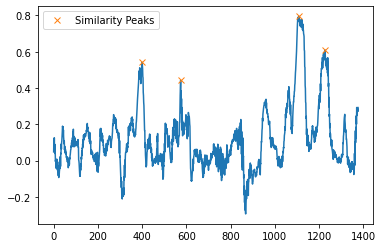

In [811]:
plt.plot(similarities)
plt.plot(peaks, similarities[peaks], "x", label="Similarity Peaks")
plt.legend()

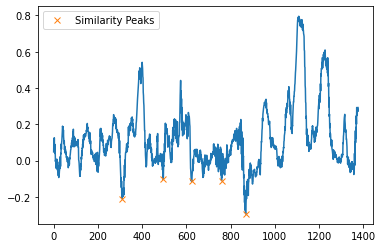

In [815]:
plt.plot(similarities)
plt.plot(lowest, similarities[lowest], "x", label="Similarity Peaks")
plt.legend()

In [831]:
top_idxs = peaks
low_idxs = lowest
pcs = target_signal
for i, idx in enumerate(top_idxs):
    save_pointcloud_clip(pcs, idx, window=48, output_path=f"match_{i+1}.mp4")

for i, idx in enumerate(low_idxs):
    save_pointcloud_clip(pcs, idx, window=48, output_path=f"outlier_{i+1}.mp4")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (935, 935) to (944, 944) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (935, 935) to (944, 944) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (935, 935) to (944, 944) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input ima

In [833]:
T = len(similarities)
similarity = similarities

window_size = 48
half_win = window_size // 2

top_idxs = peaks
low_idxs = lowest

# Compute windows: (start, end)
top_spans = [(max(0, i - half_win), min(T, i + half_win)) for i in top_idxs]
low_spans = [(max(0, i - half_win), min(T, i + half_win)) for i in low_idxs]

frames = []
for t in tqdm(range(T)):
    fig, ax = plt.subplots(figsize=(10, 3))

    # === Plot similarity curve
    ax.plot(similarity, color='C0', label='Similarity')
    ax.axvline(t, linestyle='--', color='black', linewidth=1)

    # === Highlight top spans
    for start, end in top_spans:
        ax.axvspan(start, end, color='green', alpha=0.3)

    # === Highlight low spans
    for start, end in low_spans:
        ax.axvspan(start, end, color='red', alpha=0.3)

    # === Frame info
    ax.set_xlim(0, T)
    ax.set_ylim(-0.3, 1)
    ax.set_title("Similarity to Query Over Time", fontsize=12)
    ax.set_xlabel("Time")
    ax.set_ylabel("Similarity")
    ax.tick_params(labelsize=8)
    ax.legend(fontsize=8)

    plt.tight_layout()

    # Save frame to memory
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=300)
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf).convert("RGB")
    frames.append(np.array(img))
    buf.close()

# Export animation
imageio.mimsave("similarity_with_highlighted_windows.mp4", frames, fps=60)

100%|██████████| 1377/1377 [06:21<00:00,  3.61it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (3000, 900) to (3008, 912) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
